# Approximate Bayesian Computation: Discrepancy and effective likelihood (non-parametric approximation)

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
np.random.seed(123456)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/ABC_discrepancy_effective_likelihood/"
!mkdir -p $dir

## Setup problem

In this notebook we try to infer the unknown mean $\mu$ of a unit-variance Gaussian distribution.

The data consist of $N_\mathrm{samp}$ realizations. For inference, we run $N$ simulations per value of $\mu$.

In [3]:
def simulator(mu, sigma, Nsamp=10, random_state=None):
    mu, sigma = np.atleast_1d(mu, sigma)
    return ss.norm.rvs(mu[:, None], sigma[:, None], size=(1, Nsamp), random_state=random_state)

def summary_statistic(sim):
    return np.mean(sim, axis=1)

def discrepancy(Phi, Phi_0):
    return (Phi-Phi_0)**2

def sample(mu, sigma, N):
    sims=np.zeros(N)
    for j_ in range(N):
        sim=simulator(mu, sigma)
        sims[j_] += summary_statistic(sim)[0]
    return np.mean(sims)

In [4]:
# Set the number of samples and number of simulations per mu
Nsamp=10
N=2

# Set the generating parameters that we will try to infer
mean0 = 2
sigma0 = 1

# Generate some data
d_0 = simulator(mean0, sigma0)
print("data: d_0="+str(d_0))
Phi_0 = summary_statistic(d_0)
print("summary statistic of the data: Phi_0="+str(Phi_0[0]))

data: d_0=[[ 2.4691123   1.71713666  0.4909415   0.86436763  3.21211203  1.82678535
   2.11920871  0.95576403  1.13815104 -0.10456922]]
summary statistic of the data: Phi_0=1.468901002012973


In [5]:
# Set the prior
mu = ss.uniform(-2,6)

## Generate simulations

In [6]:
# Generate some data points
N_sims=100
mu_sims=mu.rvs(N_sims)
sims=np.zeros(N_sims)
for i_ in range(N_sims):
    sims[i_]=sample(mu_sims[i_], sigma0, N)
S1_sims=discrepancy(sims,Phi_0)

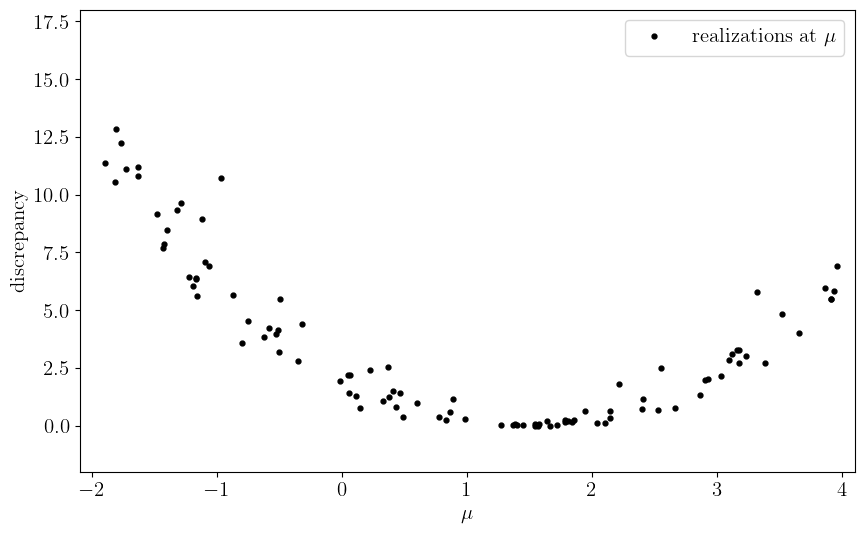

In [7]:
(xmin,xmax)=(-2.1,4.1)
(ymin,ymax)=(-2,18)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.xlabel("$\mu$")
plt.ylabel("discrepancy")
plt.legend()
plt.savefig(dir+'stochastic_process_simulations.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_simulations.png',dpi=300,bbox_inches="tight")
plt.show()

## The discrepancy as a stochastic process

With the same argument as for the parametric case, realizations of the discrepancy are $\Delta_\mu = (\Phi_0 - \hat{\Phi}_\mu)^2$ where $\hat{\Phi}_\mu$ is Gaussian-distributed with mean $\mu$ and variance $1/(N\times N_\mathrm{samp})$. Therefore
\begin{equation}
\Delta_\mu = (\Phi_0 - \mu - g )^2, \quad g \sim \mathcal{G}\left(0, \frac{1}{N\times N_\mathrm{samp}}\right).
\end{equation}

In [8]:
def discrepancy_g(mu, Phi_0, g):
    return (Phi_0 - mu - g)**2

### One realization

In [9]:
# Get the synthetic likelihood for one particular realization
sigma_g=1/np.sqrt(N*Nsamp)
g=ss.norm(0, sigma_g).rvs()
(xmin,xmax)=(-2.1,4.1)
mu_arr=np.linspace(xmin,xmax,200)
discrepancy_g_one_res=discrepancy_g(mu_arr, Phi_0, g)

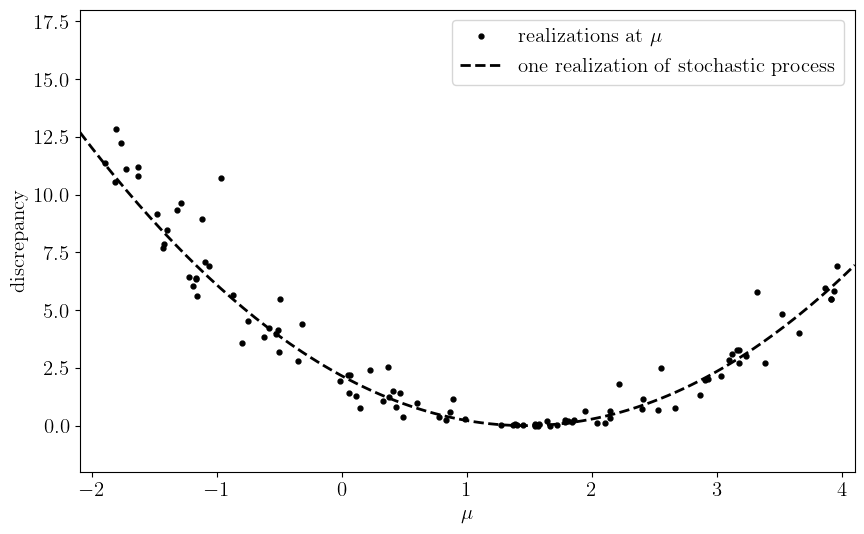

In [10]:
(xmin,xmax)=(-2.1,4.1)
(ymin,ymax)=(-2,18)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.plot(mu_arr, discrepancy_g_one_res, linestyle="--", color="black", label="one realization of stochastic process")
plt.xlabel("$\mu$")
plt.ylabel("discrepancy")
plt.legend()
plt.savefig(dir+'stochastic_process_realization.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_realization.png',dpi=300,bbox_inches="tight")
plt.show()

### Mean and quantiles

The mean and quantiles of the stochastic process can be obtained using the Percent Point Function (Inverse of the CDF).

In [11]:
g_m=ss.norm(0, sigma_g).ppf(0.1) # g value for the 0.1 quantile
g_p=ss.norm(0, sigma_g).ppf(0.9) # g value for the 0.9 quantile
g_0=ss.norm(0, sigma_g).ppf(0.5) # g value for the mean
discrepancy_g_m=discrepancy_g(mu_arr, Phi_0, g_m)
discrepancy_g_p=discrepancy_g(mu_arr, Phi_0, g_p)
discrepancy_g_0=discrepancy_g(mu_arr, Phi_0, g_0)

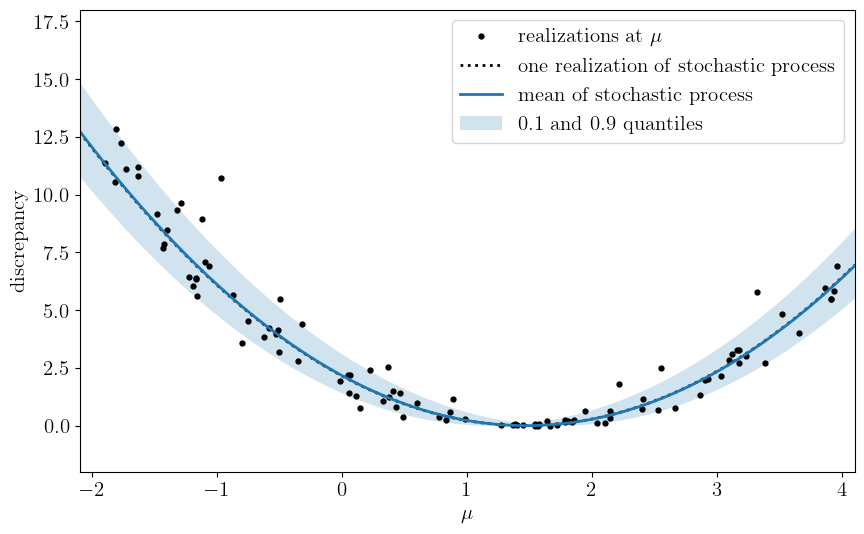

In [12]:
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.plot(mu_arr, discrepancy_g_one_res, linestyle=":", color="black", label="one realization of stochastic process")
plt.plot(mu_arr, discrepancy_g_0, linestyle="-", label="mean of stochastic process")
plt.fill_between(mu_arr, discrepancy_g_m, discrepancy_g_p, alpha=0.2, label="0.1 and 0.9 quantiles")
plt.xlabel("$\mu$")
plt.ylabel("discrepancy")
plt.legend()
plt.savefig(dir+'stochastic_process_quantiles.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_quantiles.png',dpi=300,bbox_inches="tight")
plt.show()

## Effective likelihood for rejection sampling

Based on the expression of the discrepancy $\Delta_\mu$, it is possible to compute the effective likelihood $\tilde{\mathcal{L}}_\mu \propto p(\Delta_\mu < h)$ (where $h$ is a threshold), in closed form:
\begin{equation}
\tilde{\mathcal{L}}(\mu) \propto F(\sqrt{N_\mathrm{samp}}(\Phi_0-\mu) +\sqrt{N_\mathrm{samp}h} ) - F(\sqrt{N_\mathrm{samp}}(\Phi_0-\mu) -\sqrt{N_\mathrm{samp}h} ),
\end{equation}
where $F$ is the CDF of the zero-mean unit-variance Gaussian distribution.

In [13]:
def true_likelihood(mu, Phi_0, batch_size):
    return np.exp( - 1/2.*np.log(2*np.pi/Nsamp) - Nsamp/2.*(Phi_0 - mu)**2 )

In [14]:
def effective_likelihood(mu, Phi_0, Nsamp, threshold):
    (n,h)=(Nsamp,threshold)
    return ss.norm(0,1).cdf(np.sqrt(n)*(Phi_0-mu)+np.sqrt(n*h)) \
        - ss.norm(0,1).cdf(np.sqrt(n)*(Phi_0-mu)-np.sqrt(n*h))
# equation (27) in Gutmann & Corander 2016

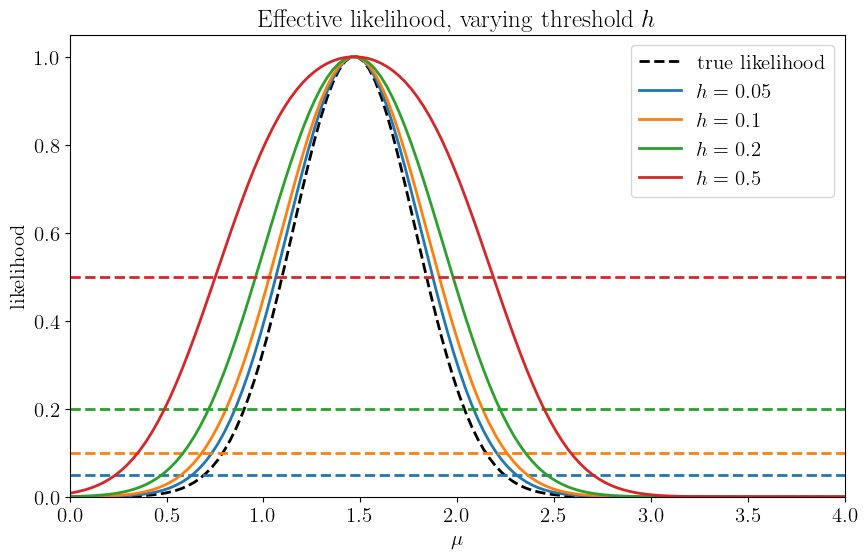

In [15]:
(xmin,xmax)=(0,4)
(ymin,ymax)=(0,1.05)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_arr, true_likelihood(mu_arr, Phi_0, Nsamp)
         /true_likelihood(mu_arr, Phi_0, Nsamp).max(), linestyle="--", color="black", label="true likelihood")
plt.plot([xmin,xmax], [0.05,0.05], linestyle="--", color='C0')
plt.plot(mu_arr, effective_likelihood(mu_arr, Phi_0, Nsamp, 0.05)
         /effective_likelihood(mu_arr, Phi_0, Nsamp, 0.05).max(), linestyle="-", color='C0', label="$h=0.05$")
plt.plot([xmin,xmax], [0.1,0.1], linestyle="--", color='C1')
plt.plot(mu_arr, effective_likelihood(mu_arr, Phi_0, Nsamp, 0.1)
         /effective_likelihood(mu_arr, Phi_0, Nsamp, 0.1).max(), linestyle="-", color='C1', label="$h=0.1$")
plt.plot([xmin,xmax], [0.2,0.2], linestyle="--", color='C2')
plt.plot(mu_arr, effective_likelihood(mu_arr, Phi_0, Nsamp, 0.2)
         /effective_likelihood(mu_arr, Phi_0, Nsamp, 0.2).max(), linestyle="-", color='C2', label="$h=0.2$")
plt.plot([xmin,xmax], [0.5,0.5], linestyle="--", color='C3')
plt.plot(mu_arr, effective_likelihood(mu_arr, Phi_0, Nsamp, 0.5)
         /effective_likelihood(mu_arr, Phi_0, Nsamp, 0.5).max(), linestyle="-", color='C3', label="$h=0.5$")
plt.xlabel("$\mu$")
plt.ylabel("likelihood")
plt.title("Effective likelihood, varying threshold $h$")
plt.legend()
plt.savefig(dir+'effective_likelihood.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'effective_likelihood.png',dpi=300,bbox_inches="tight")
plt.show()

## Regression of the discrepancy and BOLFI effective likelihood

### Gaussian process regression of the discrepancy

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W, Matern as M

In [17]:
# Mesh the input space for evaluations of the real function, the prediction and its MSE
x = np.atleast_2d(mu_arr).T

# Instanciate a Gaussian Process model
c1=1
c2=1
c3=1
kernel = C(c1, (1e-10, 1e10)) * RBF(c2, (1e-10, 1e10)) + W(c3, (1e-10, 1e5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit to data using Maximum Likelihood Estimation of the parameters
X = np.atleast_2d(mu_sims).T
gp.fit(X, S1_sims)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, y_var = gp.predict(x, return_std=True)
y_pred = y_pred.squeeze()
y_sigma = np.sqrt(y_var).squeeze()

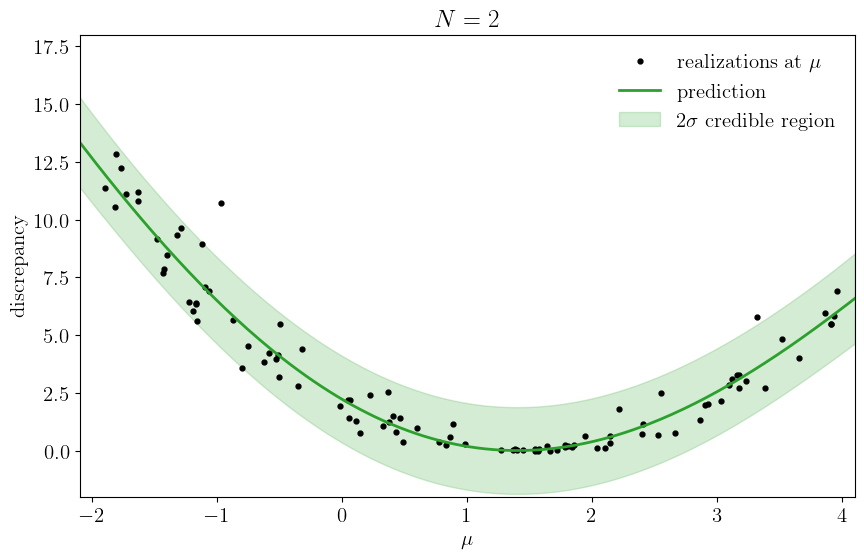

In [18]:
(xmin,xmax)=(-2.1,4.1)
(ymin,ymax)=(-2,18)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black",
         label="realizations at $\mu$")
plt.plot(x, y_pred, color='C2', label="prediction")
plt.fill_between(x.T[0], y_pred-2.*y_sigma, y_pred+2.*y_sigma, color='C2',
                 alpha=0.2, label="$2\sigma$ credible region")
plt.title("$N=2$")
plt.xlabel("$\mu$")
plt.ylabel("discrepancy")
plt.legend(frameon=False)
plt.savefig(dir+'stochastic_process_regression_N'+str(N)+'.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_regression_N'+str(N)+'.png',dpi=300,bbox_inches="tight")
plt.show()

### BOLFI effective likelihood

Regressing the discrepancy gives a prediction (posterior mean) $\mu_t$ and a standard deviation $\sigma_t$. The BOLFI effective likelihood for the considered problem is
\begin{equation}
\hat{\mathcal{L}}_\mathrm{BOLFI}(\mu) = F\left( \frac{h -\mu_t}{\sigma_t} \right).
\end{equation}

In [19]:
def effective_likelihood_regression(y_pred, sigma, threshold):
    h=threshold
    return ss.norm(0,1).cdf((h-y_pred)/sigma)
# equation (47) in Gutmann & Corander 2016

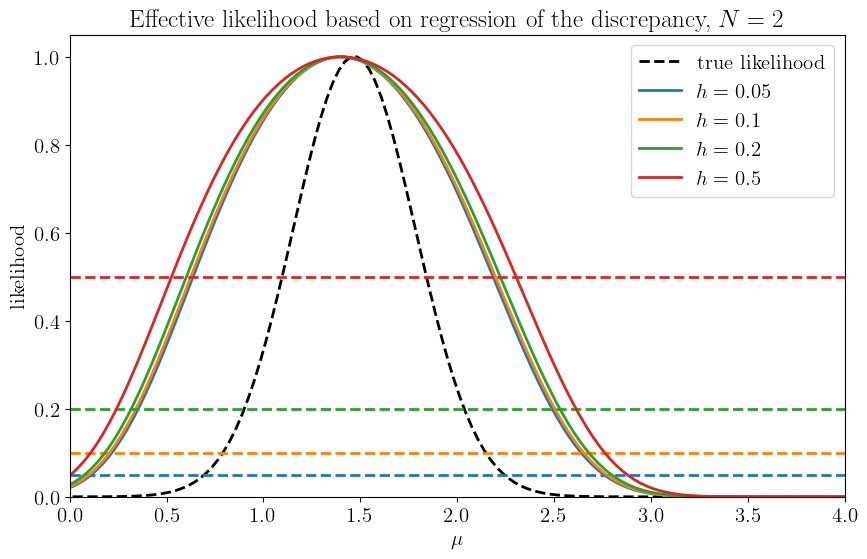

In [20]:
(xmin,xmax)=(0,4)
(ymin,ymax)=(0,1.05)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_arr, true_likelihood(mu_arr, Phi_0, Nsamp)
         /true_likelihood(mu_arr, Phi_0, Nsamp).max(), linestyle="--", color="black", label="true likelihood")
plt.plot([xmin,xmax], [0.05,0.05], linestyle="--", color='C0')
plt.plot(x, effective_likelihood_regression(y_pred, y_sigma, 0.05)
         /effective_likelihood_regression(y_pred, y_sigma, 0.05).max(), label="$h=0.05$")
plt.plot([xmin,xmax], [0.1,0.1], linestyle="--", color='C1')
plt.plot(x, effective_likelihood_regression(y_pred, y_sigma, 0.1)
         /effective_likelihood_regression(y_pred, y_sigma, 0.1).max(), label="$h=0.1$")
plt.plot([xmin,xmax], [0.2,0.2], linestyle="--", color='C2')
plt.plot(x, effective_likelihood_regression(y_pred, y_sigma, 0.2)
         /effective_likelihood_regression(y_pred, y_sigma, 0.2).max(), label="$h=0.2$")
plt.plot([xmin,xmax], [0.5,0.5], linestyle="--", color='C3')
plt.plot(x, effective_likelihood_regression(y_pred, y_sigma, 0.5)
         /effective_likelihood_regression(y_pred, y_sigma, 0.5).max(), label="$h=0.5$")
plt.xlabel("$\mu$")
plt.ylabel("likelihood")
plt.title("Effective likelihood based on regression of the discrepancy, $N=2$")
plt.legend()
plt.savefig(dir+'effective_likelihood_regression_h.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'effective_likelihood_regression_h.png',dpi=300,bbox_inches="tight")
plt.show()

### Dependence on the noise level of the BOLFI effective likelihood

In [21]:
# Reset number of simulations per mu
N=10

# Generate some data points
N_sims=100
mu_sims=mu.rvs(N_sims)
sims=np.zeros(N_sims)
for i_ in range(N_sims):
    sims[i_]=sample(mu_sims[i_], sigma0, N)
S1_sims=discrepancy(sims,Phi_0)

# Instanciate a Gaussian Process model
c1=1
c2=1
c3=1
kernel = C(c1, (1e-10, 1e10)) * RBF(c2, (1e-10, 1e10)) + W(c3, (1e-10, 1e5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit to data using Maximum Likelihood Estimation of the parameters
X = np.atleast_2d(mu_sims).T
gp.fit(X, S1_sims)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred_N10, y_var_N10 = gp.predict(x, return_std=True)
y_pred_N10 = y_pred_N10.squeeze()
y_sigma_N10 = np.sqrt(y_var_N10).squeeze()

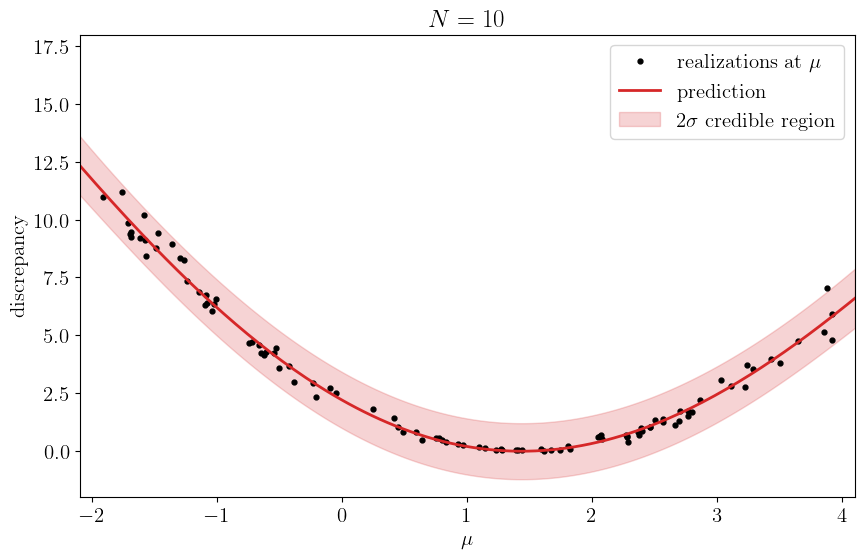

In [22]:
(xmin,xmax)=(-2.1,4.1)
(ymin,ymax)=(-2,18)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black",
         label="realizations at $\mu$")
plt.plot(x, y_pred_N10, color='C3', label="prediction")
plt.fill_between(x.T[0], y_pred_N10-2.*y_sigma_N10, y_pred_N10+2.*y_sigma_N10, color='C3',
                 alpha=0.2, label="$2\sigma$ credible region")
plt.title("$N=10$")
plt.xlabel("$\mu$")
plt.ylabel("discrepancy")
plt.legend()
plt.savefig(dir+'stochastic_process_regression_N'+str(N)+'.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_regression_N'+str(N)+'.png',dpi=300,bbox_inches="tight")
plt.show()

In [23]:
# Reset number of simulations per mu
N=100

# Generate some data points
N_sims=100
mu_sims=mu.rvs(N_sims)
sims=np.zeros(N_sims)
for i_ in range(N_sims):
    sims[i_]=sample(mu_sims[i_], sigma0, N)
S1_sims=discrepancy(sims,Phi_0)

# Instanciate a Gaussian Process model
c1=1
c2=1
c3=1
kernel = C(c1, (1e-10, 1e10)) * RBF(c2, (1e-10, 1e10)) + W(c3, (1e-10, 1e5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit to data using Maximum Likelihood Estimation of the parameters
X = np.atleast_2d(mu_sims).T
gp.fit(X, S1_sims)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred_N100, y_var_N100 = gp.predict(x, return_std=True)
y_pred_N100 = y_pred_N100.squeeze()
y_sigma_N100 = np.sqrt(y_var_N100).squeeze()

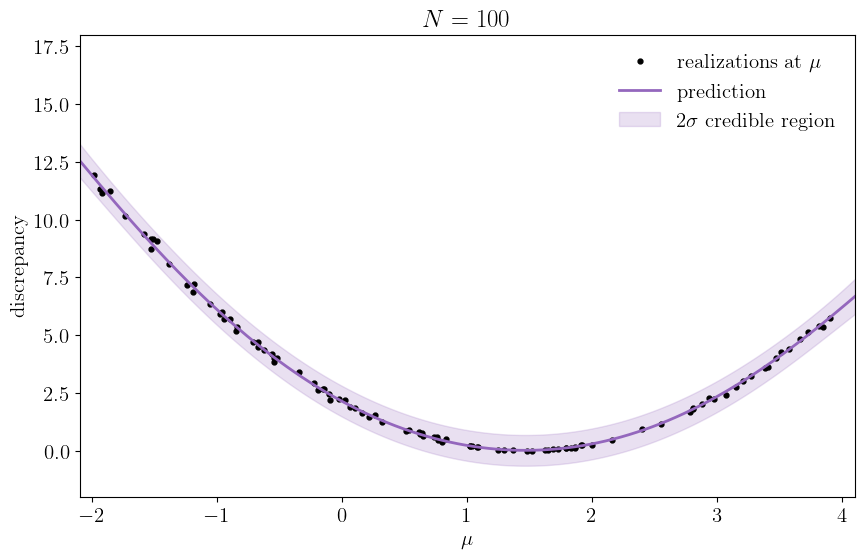

In [24]:
(xmin,xmax)=(-2.1,4.1)
(ymin,ymax)=(-2,18)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black",
         label="realizations at $\mu$")
plt.plot(x, y_pred_N100, color='C4', label="prediction")
plt.fill_between(x.T[0], y_pred_N100-2.*y_sigma_N100, y_pred_N100+2.*y_sigma_N100, color='C4',
                 alpha=0.2, label="$2\sigma$ credible region")
plt.title("$N=100$")
plt.xlabel("$\mu$")
plt.ylabel("discrepancy")
plt.legend(frameon=False)
plt.savefig(dir+'stochastic_process_regression_N'+str(N)+'.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_regression_N'+str(N)+'.png',dpi=300,bbox_inches="tight")
plt.show()

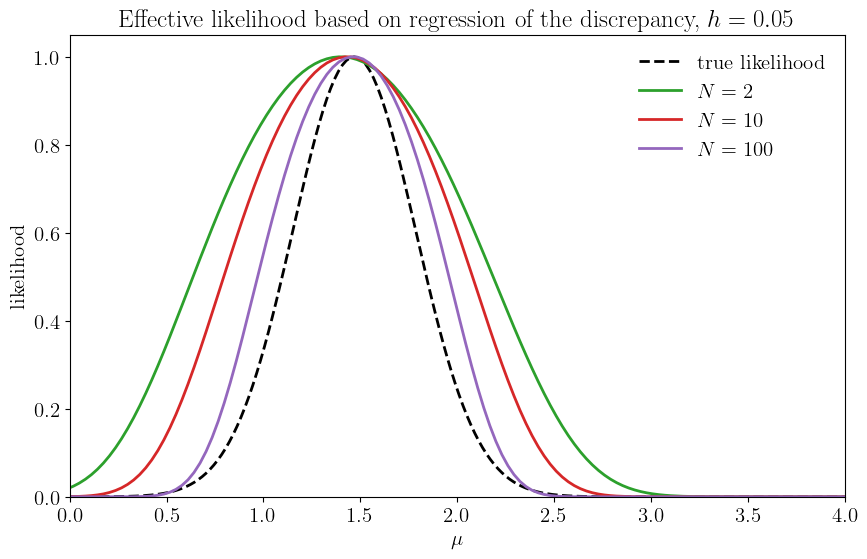

In [25]:
(xmin,xmax)=(0,4)
(ymin,ymax)=(0,1.05)
mu_arr=np.linspace(xmin,xmax,200)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_arr, true_likelihood(mu_arr, Phi_0, Nsamp)/
         true_likelihood(mu_arr, Phi_0, Nsamp).max(), linestyle="--", color="black", label="true likelihood")
plt.plot(x, effective_likelihood_regression(y_pred, y_sigma, 0.05)/
         effective_likelihood_regression(y_pred, y_sigma, 0.05).max(), color='C2', label="$N=2$")
plt.plot(x, effective_likelihood_regression(y_pred_N10, y_sigma_N10, 0.05)/
         effective_likelihood_regression(y_pred_N10, y_sigma_N10, 0.05).max(), color='C3', label="$N=10$")
plt.plot(x, effective_likelihood_regression(y_pred_N100, y_sigma_N100, 0.05)/
         effective_likelihood_regression(y_pred_N100, y_sigma_N100, 0.05).max(), color='C4', label="$N=100$")
plt.xlabel("$\mu$")
plt.ylabel("likelihood")
plt.title("Effective likelihood based on regression of the discrepancy, $h=0.05$")
plt.legend(frameon=False)
plt.savefig(dir+'effective_likelihood_regression_N.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'effective_likelihood_regression_N.png',dpi=300,bbox_inches="tight")
plt.show()